<a href="https://www.kaggle.com/code/nikhilkushwaha2529/real-time-violence-detection-mobilenet-bi-lstm?scriptVersionId=178526961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/nikhilkushwaha2529/real-time-violence-detection-mobilenet-bi-lstm?scriptVersionId=162488190" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Importing the required libraries**

In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import pandas as pd

%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

<ipython-input-1-73f57ebb70dd>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# **Visualize the Data**

In [4]:
from IPython.display import HTML
from base64 import b64encode

# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [5]:
# Classes Directories
NonViolenceVideos_Dir = "/kaggle/input/violence-combined-26-01-25-undersampled/train_undersampling/Kekerasan"
ViolenceVideos_Dir = "/kaggle/input/violence-combined-26-01-25-undersampled/train_undersampling/Non Kekerasan"

NonViolenceVideos_Dir = os.listdir(NonViolenceVideos_Dir)[:2350]


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/violence-combined-26-01-25-undersampled/train_undersampling/Kekerasan'

# **Extracting Frames**

In [2]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16
 

DATASET_DIR = "/kaggle/input/violence-combined-26-01-25-undersampled/train_undersampling"
 
CLASSES_LIST = ["Non Kekerasan","Kekerasan"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    
    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame (optional)
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    video_reader.release()
 
    return frames_list


# **Fungsi Display Sekuens frame**

In [ ]:
def display_frames_in_grid(frames_list, rows, cols, figsize=(15, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0)
    
    for i, ax in enumerate(axes.flat):
        if i < len(frames_list):
            # Jika frame sudah dinormalisasi, konversi kembali ke range [0, 255] untuk ditampilkan
            frame = (frames_list[i]).astype('uint8')
            ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Konversi BGR ke RGB
            ax.set_title(f"Frame {i+1}")
            ax.axis('off')
        else:
            ax.axis('off')  # Matikan sumbu untuk subplot yang tidak digunakan
    
    plt.show()

# **Total Frame dan Rata Durasi**

In [ ]:
# Fungsi untuk menghitung total frame dan durasi video
def get_video_info(video_path):
    # Baca video
    video = cv2.VideoCapture(video_path)
    
    # Hitung total frame
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Hitung frame rate (fps)
    fps = video.get(cv2.CAP_PROP_FPS)
    
    # Hitung durasi video (dalam detik)
    if fps > 0:
        duration = total_frames / fps
    else:
        duration = 0
    
    # Tutup video
    video.release()
    
    return total_frames, duration

# List untuk menyimpan hasil
video_info = []

# Loop melalui semua video dalam dataset
import os
dataset_path = '/kaggle/input/violence-combined-26-01-25-undersampled/train_undersampling/Non Kekerasan'
videos = os.listdir(dataset_path)[:2350]# Ganti dengan path datasetmu
for video_name in videos:
    video_path = os.path.join(dataset_path, video_name)
    total_frames, duration = get_video_info(video_path)
    video_info.append({
        'video_name': video_name,
        'total_frames': total_frames,
        'duration': duration
    })

# Konversi ke DataFrame
df = pd.DataFrame(video_info)

# Hitung total frame dan rata-rata durasi untuk seluruh dataset
total_frames_dataset = df['total_frames'].sum()
average_duration = df['duration'].mean()

print(f"Total frame dataset: {total_frames_dataset}")
print(f"Rata-rata durasi video: {average_duration:.2f} detik")

# **Visualisasi Normalisasi /255**

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Buka video
video_path = '/kaggle/input/violence-combined-2874-npy/train/Fight/1DwRGRND_1.avi'  # Ganti dengan path video Anda
cap = cv2.VideoCapture(video_path)

# Periksa apakah video berhasil dibuka
if not cap.isOpened():
    print("Error: Video tidak dapat dibuka.")
else:
    # Pilih frame tertentu (misalnya, frame ke-100)
    frame_number = 100
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Baca frame yang dipilih
    ret, frame = cap.read()
    if ret:
        # Ubah ukuran frame menjadi 64x64 piksel
        resized_frame = cv2.resize(frame, (64, 64))

        # Pilih koordinat piksel (misalnya, di (x=10, y=20))
        x, y = 10, 20
        pixel_value = resized_frame[y, x]  # Perhatikan bahwa OpenCV menggunakan format (y, x)

        # Normalisasi nilai piksel dengan membaginya oleh 255
        normalized_pixel_value = pixel_value / 255.0

        # Tampilkan frame 64x64
        plt.figure(figsize=(12, 5))

        # Tampilkan frame 64x64
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))  # Konversi BGR ke RGB
        plt.title(f"Frame {frame_number} (64x64)")
        plt.scatter(x, y, color='red', marker='x')  # Tandai koordinat piksel
        plt.axis('off')  # Sembunyikan sumbu

        # Tampilkan nilai piksel sebelum normalisasi
        plt.subplot(1, 3, 2)
        plt.bar(['B', 'G', 'R'], pixel_value, color=['blue', 'green', 'red'])
        plt.title(f"Nilai Piksel di ({x}, {y})")
        plt.ylabel("Intensitas Piksel")
        plt.ylim(0, 255)  # Rentang nilai piksel (0-255)

        # Tampilkan nilai piksel setelah normalisasi
        plt.subplot(1, 3, 3)
        plt.bar(['B', 'G', 'R'], normalized_pixel_value, color=['blue', 'green', 'red'])
        plt.title(f"Nilai Piksel di ({x}, {y}) (Normalisasi)")
        plt.ylabel("Intensitas Piksel (0-1)")
        plt.ylim(0, 1)  # Rentang nilai piksel setelah normalisasi (0-1)

        # Tampilkan plot
        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: Tidak bisa membaca frame ke-{frame_number}.")

    # Tutup video
    cap.release()

# **Sekuens Frame**

In [ ]:
frames_list = frames_extraction("/kaggle/input/violence-combined-2874-npy/train/Fight/1DwRGRND_1.avi")
# Tampilkan frame dalam grid
rows = 4  # Jumlah baris dalam grid
cols = 4  # Jumlah kolom dalam grid
display_frames_in_grid(frames_list, rows, cols)

# **Mengambil 2425 video random dari non kekerasan**

In [ ]:
#import os
#import random

# Path ke dataset
#dataset_path = NonViolenceVideos_Dir # Ganti dengan path datasetmu

# Ambil semua nama video dalam direktori
#all_video_names = os.listdir(dataset_path)

# Pastikan jumlah video yang diminta tidak melebihi total video yang tersedia
#if len(all_video_names) < 2425:
#    raise ValueError("Jumlah video yang diminta melebihi total video yang tersedia.")

# Ambil 2425 video secara acak
#random_video_names = random.sample(all_video_names, 2425)

# Inisialisasi list untuk menyimpan informasi video
#video_info = []

# Loop melalui 2425 video yang terpilih
#for video_name in random_video_names:
#    video_path = os.path.join(dataset_path, video_name)
#    total_frames, duration = get_video_info(video_path)  # Pastikan fungsi get_video_info sudah didefinisisi
#    video_info.append({
#       'video_name': video_name,
#        'total_frames': total_frames,
#        'duration': duration
#    })

# Cetak informasi video (opsional)
#for info in video_info:
#    print(info)

# **Rata - Rata fps dari tiap kelas**

In [ ]:
import cv2
import os

def calculate_average_fps_and_total_duration(directory):
    total_fps = 0
    total_duration = 0  # Total durasi dalam detik
    num_videos = 0

    # Loop melalui semua file dalam direktori
    for filename in os.listdir(directory):
        # Cek apakah file adalah video (ekstensi .mp4, .avi, dll.)
        if filename.endswith((".mp4", ".avi", ".mov", ".mkv")):
            # Path lengkap ke video
            video_path = os.path.join(directory, filename)
            
            # Buka video
            cap = cv2.VideoCapture(video_path)
            
            # Periksa apakah video berhasil dibuka
            if not cap.isOpened():
                print(f"Error: Tidak bisa membuka video {filename}")
                continue
            
            # Ambil FPS dan jumlah frame dari video
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
            
            # Hitung durasi video (dalam detik)
            duration = frame_count / fps if fps > 0 else 0
            
            # Tampilkan informasi video
            print(f"Video: {filename}")
            print(f"  FPS: {fps}")
            print(f"  Jumlah Frame: {frame_count}")
            print(f"  Durasi: {duration:.2f} detik\n")
            
            # Tambahkan FPS dan durasi ke total
            total_fps += fps
            total_duration += duration
            num_videos += 1
            
            # Tutup video
            cap.release()

    # Hitung rata-rata FPS dan total durasi
    if num_videos > 0:
        average_fps = total_fps / num_videos
        print(f"Rata-rata FPS dari {num_videos} video: {average_fps:.2f}")
        print(f"Total durasi semua video: {total_duration:.2f} detik")
    else:
        print("Tidak ada video yang ditemukan di direktori.")

# Path ke direktori yang berisi video
video_directory = "/kaggle/input/violence-combined-2874-npy/train/NonFight"

# Hitung rata-rata FPS dan total durasi
calculate_average_fps_and_total_duration(video_directory)

# **Creating the Data**

In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import pandas as pd

%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

<ipython-input-1-73f57ebb70dd>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16
 

DATASET_DIR = "/kaggle/input/violence-combined-26-01-25-undersampled/train_undersampling"
 
CLASSES_LIST = ["Non Kekerasan","Kekerasan"]

In [3]:
def create_dataset():
 
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes.
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths

In [4]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()#

In [5]:
# Konversi ke tensor PyTorch dan pindahkan ke GPU
#features_tensor = torch.tensor(features, dtype=torch.float32).to('cuda')
#labels_tensor = torch.tensor(labels, dtype=torch.long).to('cuda')

In [6]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

# YOU CAN SKIP ALL ABOVE CODES AND PROCEED THE CODE BELOW AFTER SAVE THE NPY

In [7]:
features, labels, video_files_paths = np.load("/kaggle/input/violence-combined-undersampled-npy-260125/features.npy") , np.load("/kaggle/input/violence-combined-undersampled-npy-260125/labels.npy") ,  np.load("/kaggle/input/violence-combined-undersampled-npy-260125/video_files_paths.npy")

In [8]:
assert len(features) == len(labels), "Jumlah video dan label tidak sesuai!"

from collections import defaultdict

# Dictionary untuk menyimpan jumlah frame per kelas
class_frame_counts = defaultdict(int)

# Iterasi setiap video dalam dataset
for i in range(len(features)):
    class_label = labels[i]  # Ambil label kelas video
    num_frames = len(features[i])  # Ambil jumlah frame dalam video
    class_frame_counts[class_label] += num_frames  # Tambahkan ke jumlah total kelas

# Tampilkan hasil
for class_label, total_frames in class_frame_counts.items():
    print(f"Kelas {class_label}: {total_frames} frames")


Kelas 0: 38800 frames
Kelas 1: 45984 frames


# 
**Encoding and Splitting Training-Testing Sets**

In [9]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
print(one_hot_encoded_labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [11]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [12]:
print(features_train.shape,labels_train.shape)
print(features_test.shape, labels_test.shape)

(4769, 16, 64, 64, 3) (4769, 2)
(530, 16, 64, 64, 3) (530, 2)


# **Importing MobileNet and Fine-Tuning it.**

In [13]:
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large

mobilenet = MobileNetV3Large(include_top=False , weights="imagenet")

#Fine-Tuning to make the last layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
    layer.trainable=False

#mobilenet.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
len(mobilenet.layers)

187

# **Building The Model**

In [15]:

# Import library untuk model dan lapisan neural network
from tensorflow.keras.layers import (
    Input, TimeDistributed, Flatten, LSTM, Bidirectional, 
    Dense, Dropout, BatchNormalization, 
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2  # Regularisasi L2
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau 
import tensorflow as tf

def create_model():
    # Input Layer
    inputs = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

    x = TimeDistributed(mobilenet)(inputs)

    # Dropout
    x = TimeDistributed(Dropout(0.25))(x)

    # Flatten tiap frame
    x = TimeDistributed(Flatten())(x)

    # Bidirectional LSTM dengan return_sequences=True
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    x = Bidirectional(lstm_fw, backward_layer=lstm_bw)(x)

    # Lapisan Dense dengan Batch Normalization

    dense = Dropout(0.25)(x)
    dense = Dense(512, activation='relu')(dense)
    
    dense = Dropout(0.25)(x)
    dense = Dense(256, activation='relu')(dense)

    dense = Dropout(0.25)(dense)
    dense = Dense(128, activation='relu')(dense)

    dense = Dropout(0.25)(dense)
    dense = Dense(64, activation='relu')(dense)

    dense = Dropout(0.25)(dense)

    dense = Dense(32, activation='relu')(dense)

    dense = Dropout(0.25)(dense)

    # Output
    outputs = Dense(len(CLASSES_LIST), activation='sigmoid')(dense)
    model = Model(inputs, outputs)
    model.summary()

    return model

In [16]:
from tensorflow.keras.utils import plot_model
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
#plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 16, 64, 64, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 16, 2, 2, 960)       │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 2, 2, 960)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 16, 3840)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │         991,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,047,778 (15.44 MB)

 Trainable params: 3,136,138 (11.96 MB)

 Non-trainable params: 911,640 (3.48 MB)

# **Specifying Callbacks and Fitting**

In [ ]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Menentukan learning rate awal
initial_lr = 0.001

# Membuat optimizer dengan custom learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_lr)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
##MINI-GD
# Compiling the model 
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])
 
# Fitting the model 
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4,
                                         shuffle = True, validation_split = 0.1, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/30
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 209s 119ms/step - accuracy: 0.5324 - loss: 0.6930 - val_accuracy: 0.5681 - val_loss: 0.6824 - learning_rate: 0.0010
Epoch 2/30
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 111s 104ms/step - accuracy: 0.5380 - loss: 0.6882 - val_accuracy: 0.6373 - val_loss: 0.6693 - learning_rate: 0.0010
Epoch 3/30
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 112s 104ms/step - accuracy: 0.5545 - loss: 0.6829 - val_accuracy: 0.6436 - val_loss: 0.6621 - learning_rate: 0.0010
Epoch 4/30
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 110s 102ms/step - accuracy: 0.5514 - loss: 0.6820 - val_accuracy: 0.6646 - val_loss: 0.6576 - learning_rate: 0.0010
Epoch 5/30
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 108s 101ms/step - accuracy: 0.5858 - loss: 0.6671 - val_accuracy: 0.6688 - val_loss: 0.6362 - learning_rate: 0.0010
Epoch 6/30
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 108s 101ms/step - accuracy: 0.6100 - loss: 0.6563 - val_accuracy: 0.6730 - val_loss: 0.6350 - learning_rate: 0.0010
Epoch 7/30
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 108s 101ms

In [20]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7643 - loss: 0.4821


In [35]:
MoBiLSTM_model.save("modelv3L-82.38-1502.keras")

In [22]:
from tensorflow.keras.models import load_model

path = '/kaggle/working/modelv3L-80.39-1502.keras'

model = load_model(path)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 16, 64, 64, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 16, 2, 2, 960)       │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 2, 2, 960)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 16, 3840)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │       1,999,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,072,036 (19.35 MB)

 Trainable params: 4,160,394 (15.87 MB)

 Non-trainable params: 911,640 (3.48 MB)

 Optimizer params: 2 (12.00 B)

# **Heatmap**

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
def load_video(video_path, sequence_length=SEQUENCE_LENGTH, img_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    cap = cv2.VideoCapture(video_path)

    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Jika video lebih pendek dari sequence_length, duplikasi frame terakhir
    for _ in range(sequence_length):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)  # Resize frame
        frame = frame / 255.0  # Normalisasi RGB (0-1)
        frames.append(frame)

    cap.release()

    # Jika frame kurang dari SEQUENCE_LENGTH, pad dengan frame terakhir
    while len(frames) < sequence_length:
        frames.append(frames[-1])  # Duplicate last frame if necessary

    frames = np.array(frames)
    frames = np.expand_dims(frames, axis=0)  # Tambahkan batch dimension
    return frames


In [ ]:
attention_model = Model(inputs=MoBiLSTM_model.input, outputs=MoBiLSTM_model.get_layer('attention_weights').output)

In [ ]:
video_path = "/kaggle/input/primer-260125/K2.mp4"

# Load video dan siapkan sebagai input model
video_input = load_video(video_path)

# Pastikan bentuk input sesuai dengan model
print("Shape of processed video:", video_input.shape)
# Expected output: (1, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# Lakukan prediksi dengan model
attention_weights = attention_model.predict(video_input)

# Visualisasi attention heatmap
import matplotlib.pyplot as plt
import seaborn as sns

attention_weights = attention_weights.squeeze()  # (SEQUENCE_LENGTH,)

plt.figure(figsize=(10, 4))
sns.heatmap([attention_weights], cmap='viridis', annot=True, xticklabels=np.arange(len(attention_weights)))
plt.xlabel("Frame ke-")
plt.ylabel("Attention Score")
plt.title("Attention Heatmap pada Frame Video")
plt.show()


In [ ]:
important_frame_idx = np.argmax(attention_weights)

# Ambil frame dengan perhatian tertinggi dari video input
important_frame = video_input[0, important_frame_idx]

# Konversi frame ke format gambar untuk ditampilkan
plt.imshow((important_frame * 255).astype('uint8'))
plt.title(f"Frame ke-{important_frame_idx} dengan Attention Tertinggi")
plt.axis("off")
plt.show()


# **Model Evaluation**

In [21]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the Epochs Count
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

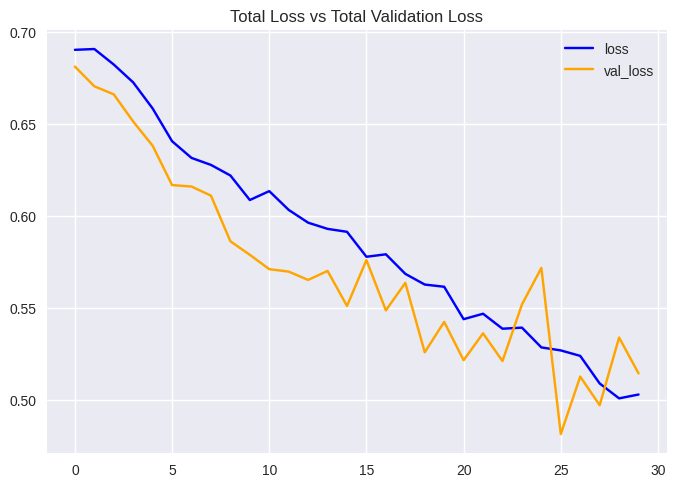

In [22]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

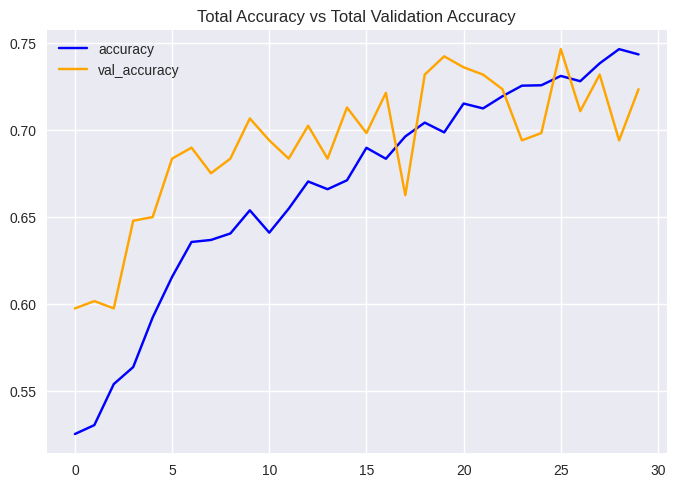

In [23]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# **Predicting the Test Set**

In [24]:
labels_predict = MoBiLSTM_model.predict(features_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step


In [25]:
# Decoding the data to use in Metrics

labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [26]:
labels_test_normal.shape , labels_predict.shape

((530,), (530,))

Accuracy Score

In [27]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.7396226415094339



Confusion Matrix

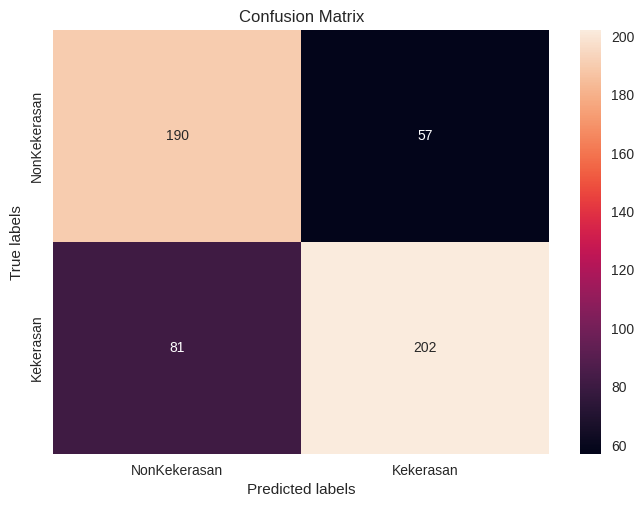

In [28]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NonKekerasan', 'Kekerasan']); ax.yaxis.set_ticklabels(['NonKekerasan', 'Kekerasan']);

# **ROC-AUC Curve**

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Pastikan labels_test berbentuk 1D
labels_test = labels_test.ravel()

# Prediksi probabilitas menggunakan model Keras
y_pred_proba = MoBiLSTM_model.predict(features_test)

# Cek bentuk output prediksi
print("Shape y_pred_proba sebelum reshape:", y_pred_proba.shape)

# Jika output (530, 2), ambil hanya kelas positif
if y_pred_proba.shape[1] == 2:  
    y_pred_proba = y_pred_proba[:, 1]  # Ambil hanya kelas positif
else:
    y_pred_proba = y_pred_proba.ravel()  # Jika sudah (530, 1), pastikan jadi 1D

print("Shape y_pred_proba setelah reshape:", y_pred_proba.shape)

# Hitung ROC Curve
fpr, tpr, thresholds = roc_curve(labels_test, y_pred_proba)

# Hitung AUC Score
auc_score = roc_auc_score(labels_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

# Cari threshold yang paling optimal (misalnya dengan Youden’s J statistic)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Threshold terbaik: {optimal_threshold}")


# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
Shape y_pred_proba sebelum reshape: (530, 2)
Shape y_pred_proba setelah reshape: (530,)


ValueError: Found input variables with inconsistent numbers of samples: [1060, 530]

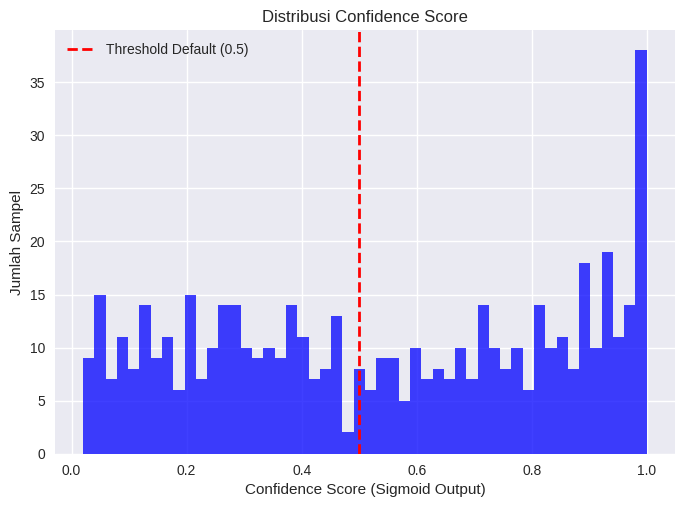

In [39]:
import matplotlib.pyplot as plt

plt.hist(y_pred_proba, bins=50, alpha=0.75, color='blue')
plt.axvline(0.5, color='red', linestyle='dashed', linewidth=2, label="Threshold Default (0.5)")
plt.xlabel("Confidence Score (Sigmoid Output)")
plt.ylabel("Jumlah Sampel")
plt.title("Distribusi Confidence Score")
plt.legend()
plt.show()


Classification Report

In [30]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       247
           1       0.78      0.71      0.75       283

    accuracy                           0.74       530
   macro avg       0.74      0.74      0.74       530
weighted avg       0.74      0.74      0.74       530



# **Prediction Frame By Frame**

In [ ]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame 
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        if predicted_class_name == "Kekerasan":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

In [ ]:
plt.style.use("default")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path): 

    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))
        
    for counter, random_index in enumerate(random_range, 1):
        
        plt.subplot(5, 4, counter)

        # Set the current frame position of the video.  
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
          
        ok, frame = video_reader.read() 

        if not ok:
          break 

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame);ax.figure.set_size_inches(20,20);plt.tight_layout()
                            
    video_reader.release()

In [ ]:
# Construct the output video path.
test_videos_directory = '/kaggle/input/primer-260125'
os.makedirs(test_videos_directory, exist_ok = True)
 
output_video_file_path = f'{test_videos_directory}/ta_2.mp4'

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/kaggle/input/primer-260125/K10.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
Play_Video(input_video_file_path)

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/kaggle/input/rwf2000/RWF-2000/val/Fight/1MVS2QPWbHc_1.avi"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

In [ ]:
# Play the actual video
Play_Video(input_video_file_path)

# **Prediction For The Video**

In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}\nNama: {video_file_path}')
        
    video_reader.release()

In [ ]:
primer = os.listdir('/kaggle/input/primer-260125')
path = '/kaggle/input/primer-260125/'
for vid in primer:
    # Specifying video to be predicted
    input_video_file_path = path+vid
    predict_video(input_video_file_path, SEQUENCE_LENGTH)

In [ ]:
# Specifying video to be predicted
input_video_file_path = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/NV_23.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
Play_Video(input_video_file_path)